# Image processing pipeline - tuned on library

In [1]:
# Import necessary packages
#%pip install imutils opencv-python simplekml palettable gdown
import helper_functions as hf
import plotting as pl
import stitching as st
import gdown
import os
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
import cv2
import imageio
import imutils
from palettable import colorbrewer
from scipy import ndimage
from collections import Counter
cv2.ocl.setUseOpenCL(False)

In [125]:
# Variables
gdrive = False # Download data from google drive
link = 'https://drive.google.com/file/d/1IUIAgR7p-RBC8_UzkbhMlKweXaQEek8x/view?usp=sharing'
#'https://drive.google.com/file/d/1ANJ_Hq3C42Zfka_wIDX7wgbH_hwcUbGn/view?usp=sharing' # gdrive link
imgDir = 'data/lsm/Flight 1 - Library/thermal-data/' # Local directory to images
imageType, cmap = False, colorbrewer.get_map('RdYlBu', 'diverging', 11, reverse=True).mpl_colormap # True if RGB images, False if numpy arrays. Choose matplotlib cmap for thermal
pathFile = 'data/lsm/Flight 1.csv' # Flight path .csv file
outName = 'library'
utcDiff = -1 # Time difference to UTC (-1 for BST)
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)','speed(mps)'] # Columns used from the path file
filters = ['altitude(m)', 'timestamp', 'speed(mps)'] # Altitude criteria for using imagery
filtValues = [[119.7, 120.3], [1619811011923,1619811099149], [4.85,5.15]]
utmZone, hemisphere = '31n', 'north' # Specify UTM coordinate zone
resolution = 6 # Other resolution for plots
useCentre = True # True if only using center of images
skip = 20 # Plot every nth image for path
height = 120 # Height of camera
fov, pixels = 69, 640 # Long axis field of view and number of pixels of camera
pxSize = (height*np.tan(np.deg2rad(fov/2)))/(pixels/2) # Specify pixel size (m) - for now

In [126]:
# Download from google drive if gdrive is True
#%capture
if gdrive: 
    zippath = imgDir[:-1]+'.zip'
    downLink = link.split('/d/')[1].split('/view')[0]
    ! gdown -O $zippath 'https://drive.google.com/uc?export=download&id='$downLink
    ! unzip $zippath -d $imgDir
    ! rm $zippath

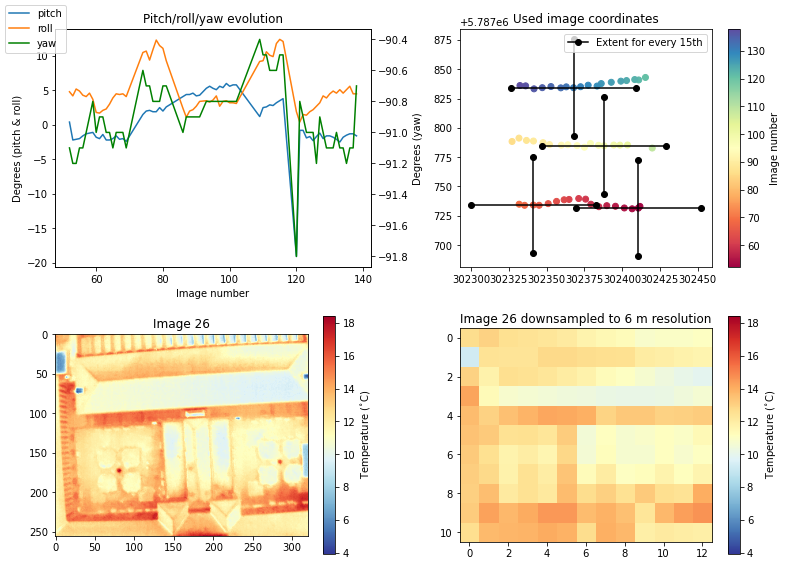

In [127]:
# Create dataframe of images associated with flight information
merged = hf.img_info_merge(imgDir, pathFile, utcDiff, pathColumns, imageType)
merged = hf.filter_imgs(merged, filters, filtValues)
merged, myProj = hf.reproject_coords(merged, utmZone, hemisphere)
idf = hf.correct_coords(merged, 20)

# Plot summary of flight and example image
fig, axs = plt.subplots(2,2,figsize=[11,8])
fig, axs[0,0] = pl.plot_orientation(fig, axs[0,0], merged) 
xq, yq, xCoords, yCoords = hf.use_centre(useCentre, idf, pxSize)
fig, axs[0,1] = pl.plot_route(fig, axs[0,1], idf, xq, yq, pxSize)
fig, axs[1,0] = pl.plot_image(fig, axs[1,0], idf, xq, yq, pxSize, pxSize, cmap, imageType=imageType)
fig, axs[1,1] = pl.plot_image(fig, axs[1,1], idf, xq, yq, pxSize, resolution, cmap, imageType=imageType)
fig.tight_layout()
plt.show()

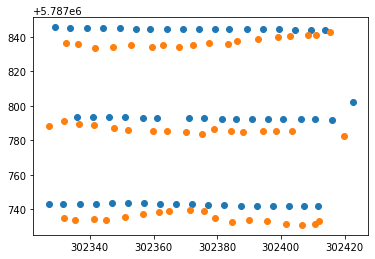

In [128]:
plt.scatter(idf['x'],idf['y'])
plt.scatter(idf['xc'],idf['yc'])

Images processed: 53it [00:01, 43.98it/s] 


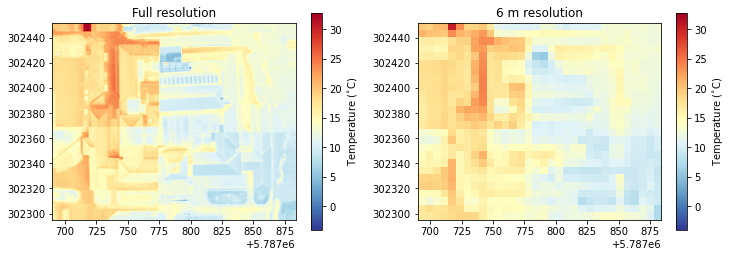

In [129]:
# Stitch images based on xy coordinates
xygrid, extent = st.img_xymerge(idf, xCoords, yCoords, xq, yq, pxSize, imageType=imageType)

# Plot output and downsample
fig, axs = plt.subplots(1,2,figsize=[12,4])
fig, axs[0] = pl.plot_array(fig, axs[0], xygrid, extent, cmap=cmap, title='Full resolution', imageType=imageType)
fig, axs[1] = pl.plot_array(fig, axs[1], hf.downsample_arr(xygrid,pxSize,resolution), extent, cmap=cmap, title=str(resolution)+' m resolution', imageType=imageType, scale=xygrid)

In [130]:
def plot_kml(arr, conv, name, pixels, rot=False, scale=False):
    fig, ax = pl.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                            urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                            pixels=pixels)
    if len(arr.shape) > 2: arr = arr.mean(axis=2)
    if rot is not False: arr = np.ma.masked_where(ndimage.rotate(arr, rot)<1e-2, ndimage.rotate(arr, rot))
    #single = rot < 1e-1, rot)/255*40-10
    single = arr
    if scale is False: scale = single
    cs = ax.imshow(single,extent=(conv[0].min(),conv[0].max(),conv[1].min(),conv[1].max()), cmap=cmap, vmin=scale.min(),vmax=scale.max())
    ax.set_axis_off()
    fig.savefig(name+'.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)
    return cs, single
    
def plot_kml_legend(cs, name, label='Temperature ($^{\circ}$C)'):
    fig = plt.figure(figsize=(1.0, 4.0))
    ax = fig.add_axes([0.07, 0.05, 0.27, 0.9])
    cb = fig.colorbar(cs, cax=ax)
    cb.set_label(label, rotation=-90, color='k', labelpad=20, fontsize=13)
    fig.tight_layout()
    fig.savefig(name+'.png', format='png', bbox_inches = 'tight', pad_inches = 0.2)
    
def plot_kml_path(df, conv, name, pixels, bounds=False):
    if bounds is not False: x, y = df.longitude[bounds[0]:bounds[1]], df.latitude[bounds[0]:bounds[1]]
    else: x,y = df.longitude, df.latitude
    fig, ax = pl.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                             urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                             pixels=pixels)
    ax.plot(x,y,'k-',linewidth=2,label='raw')
    ax.set_axis_off()
    fig.savefig(name+'.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


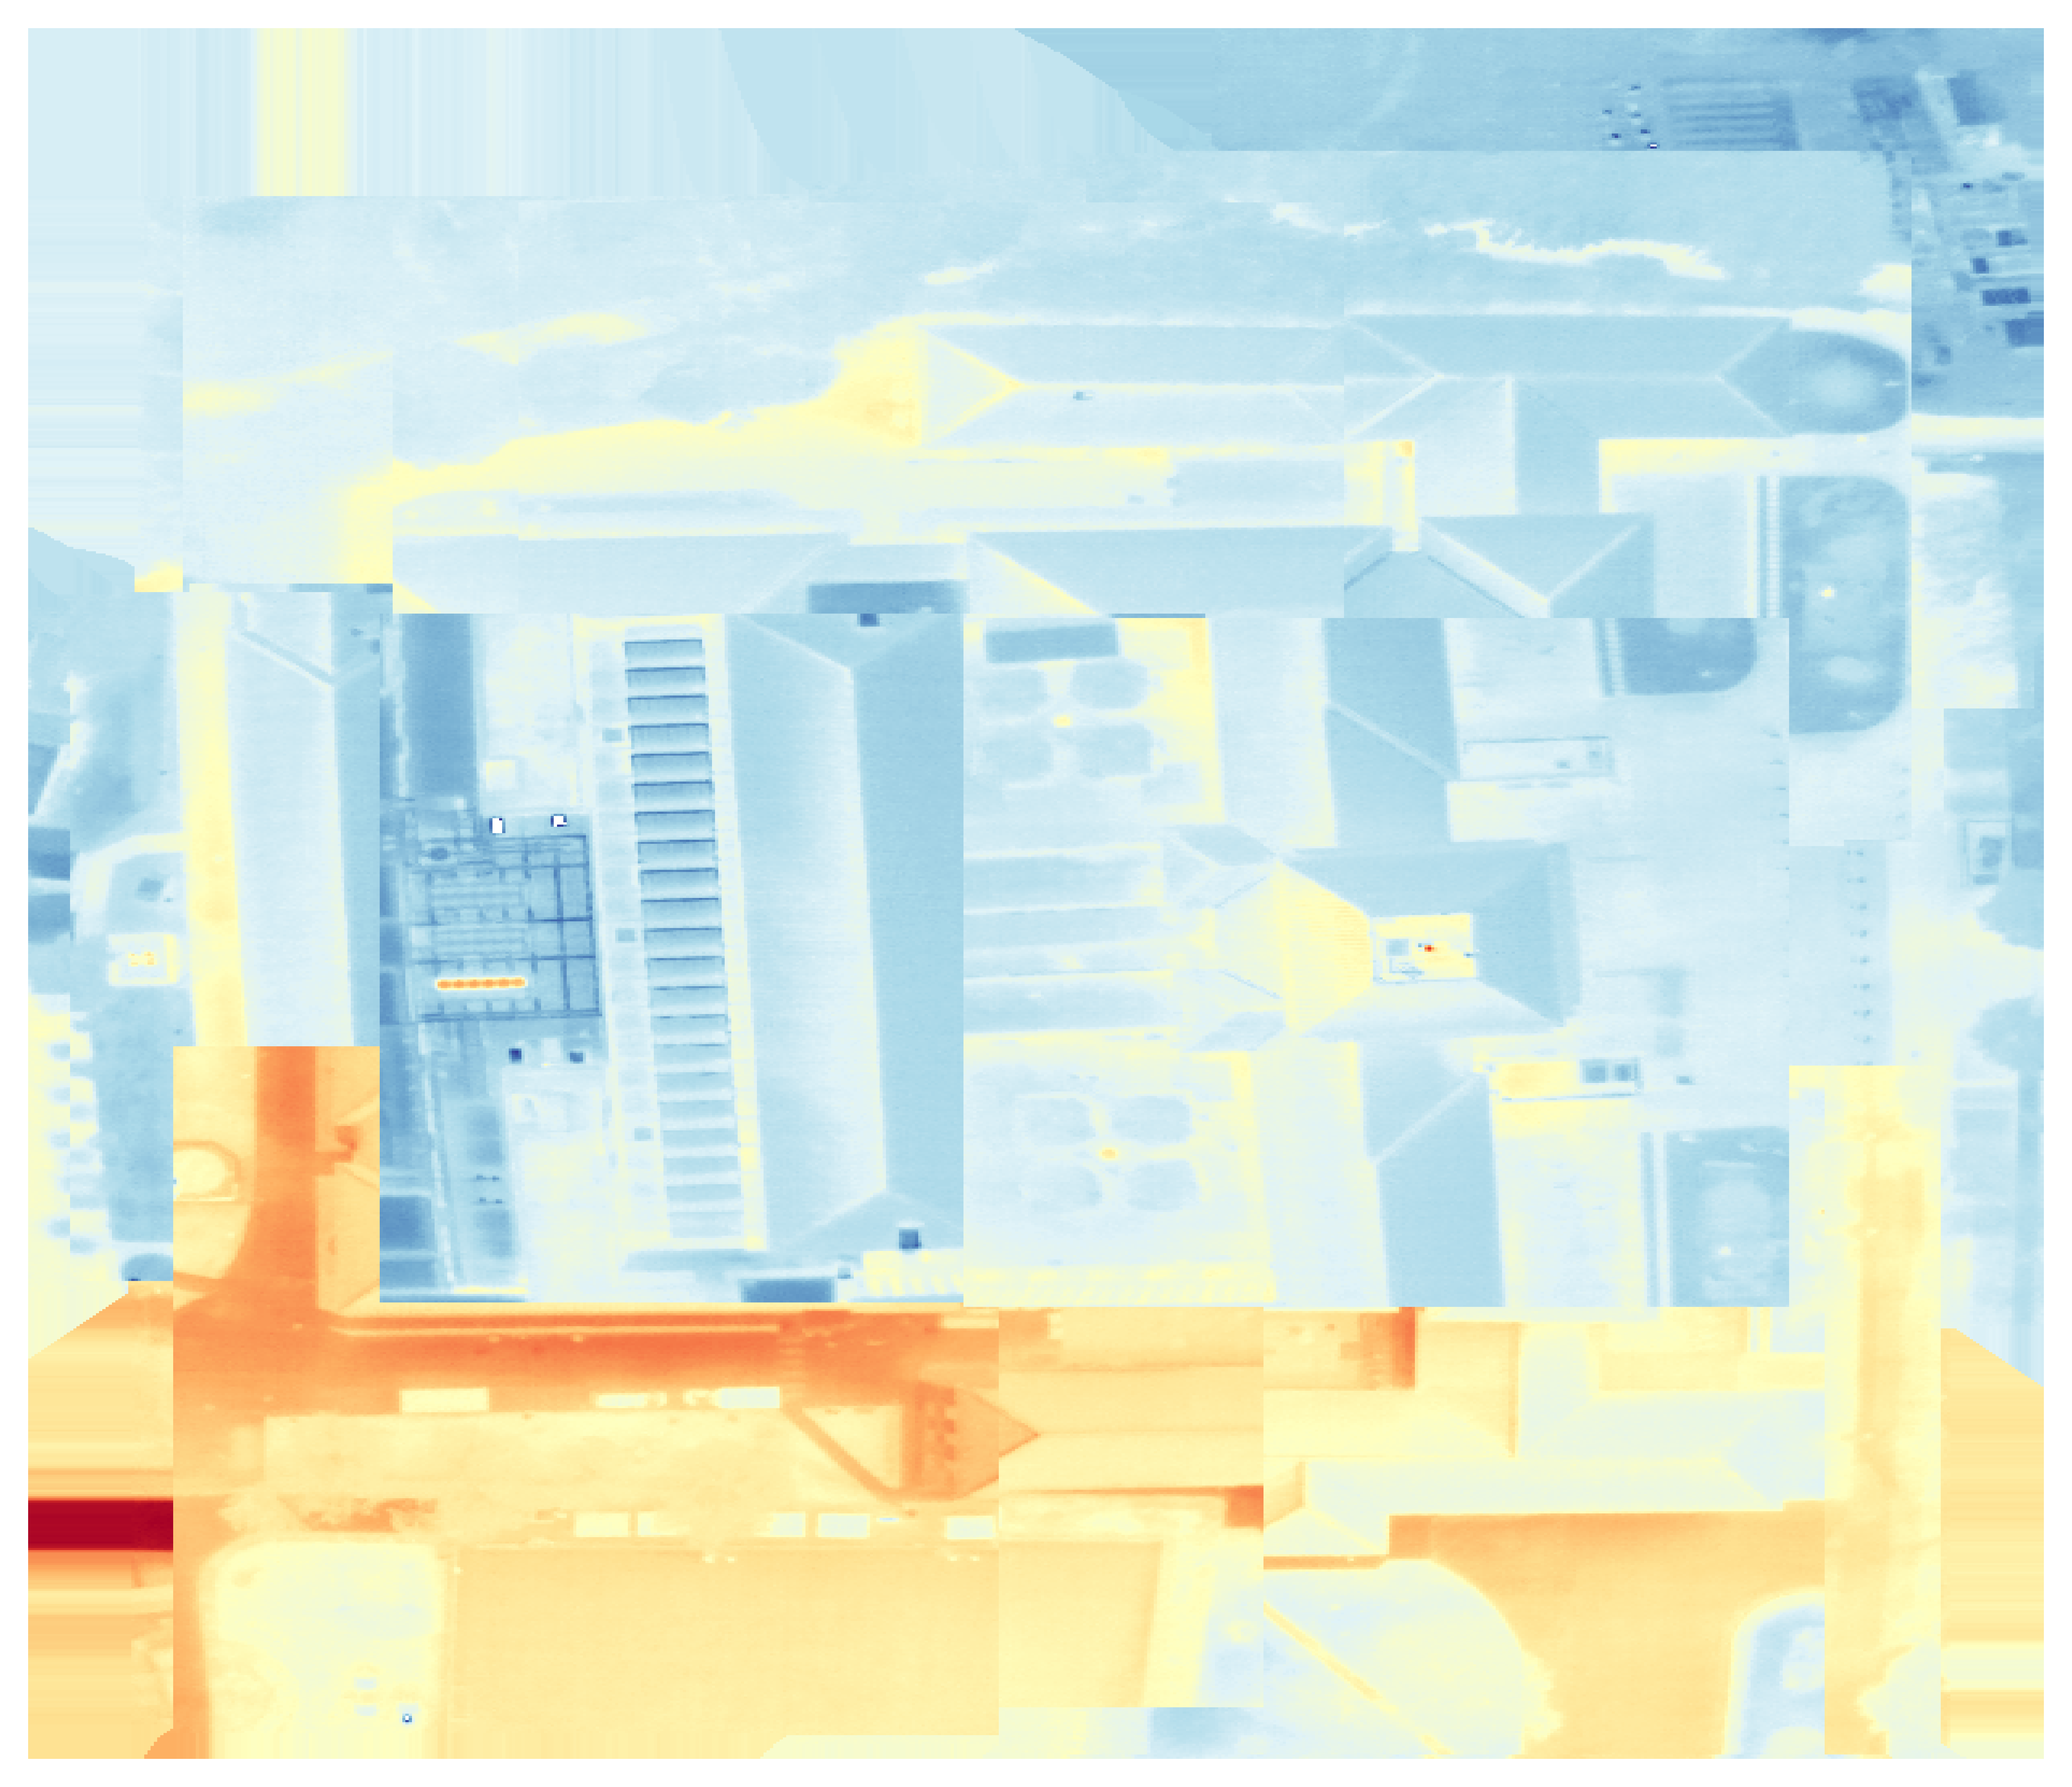

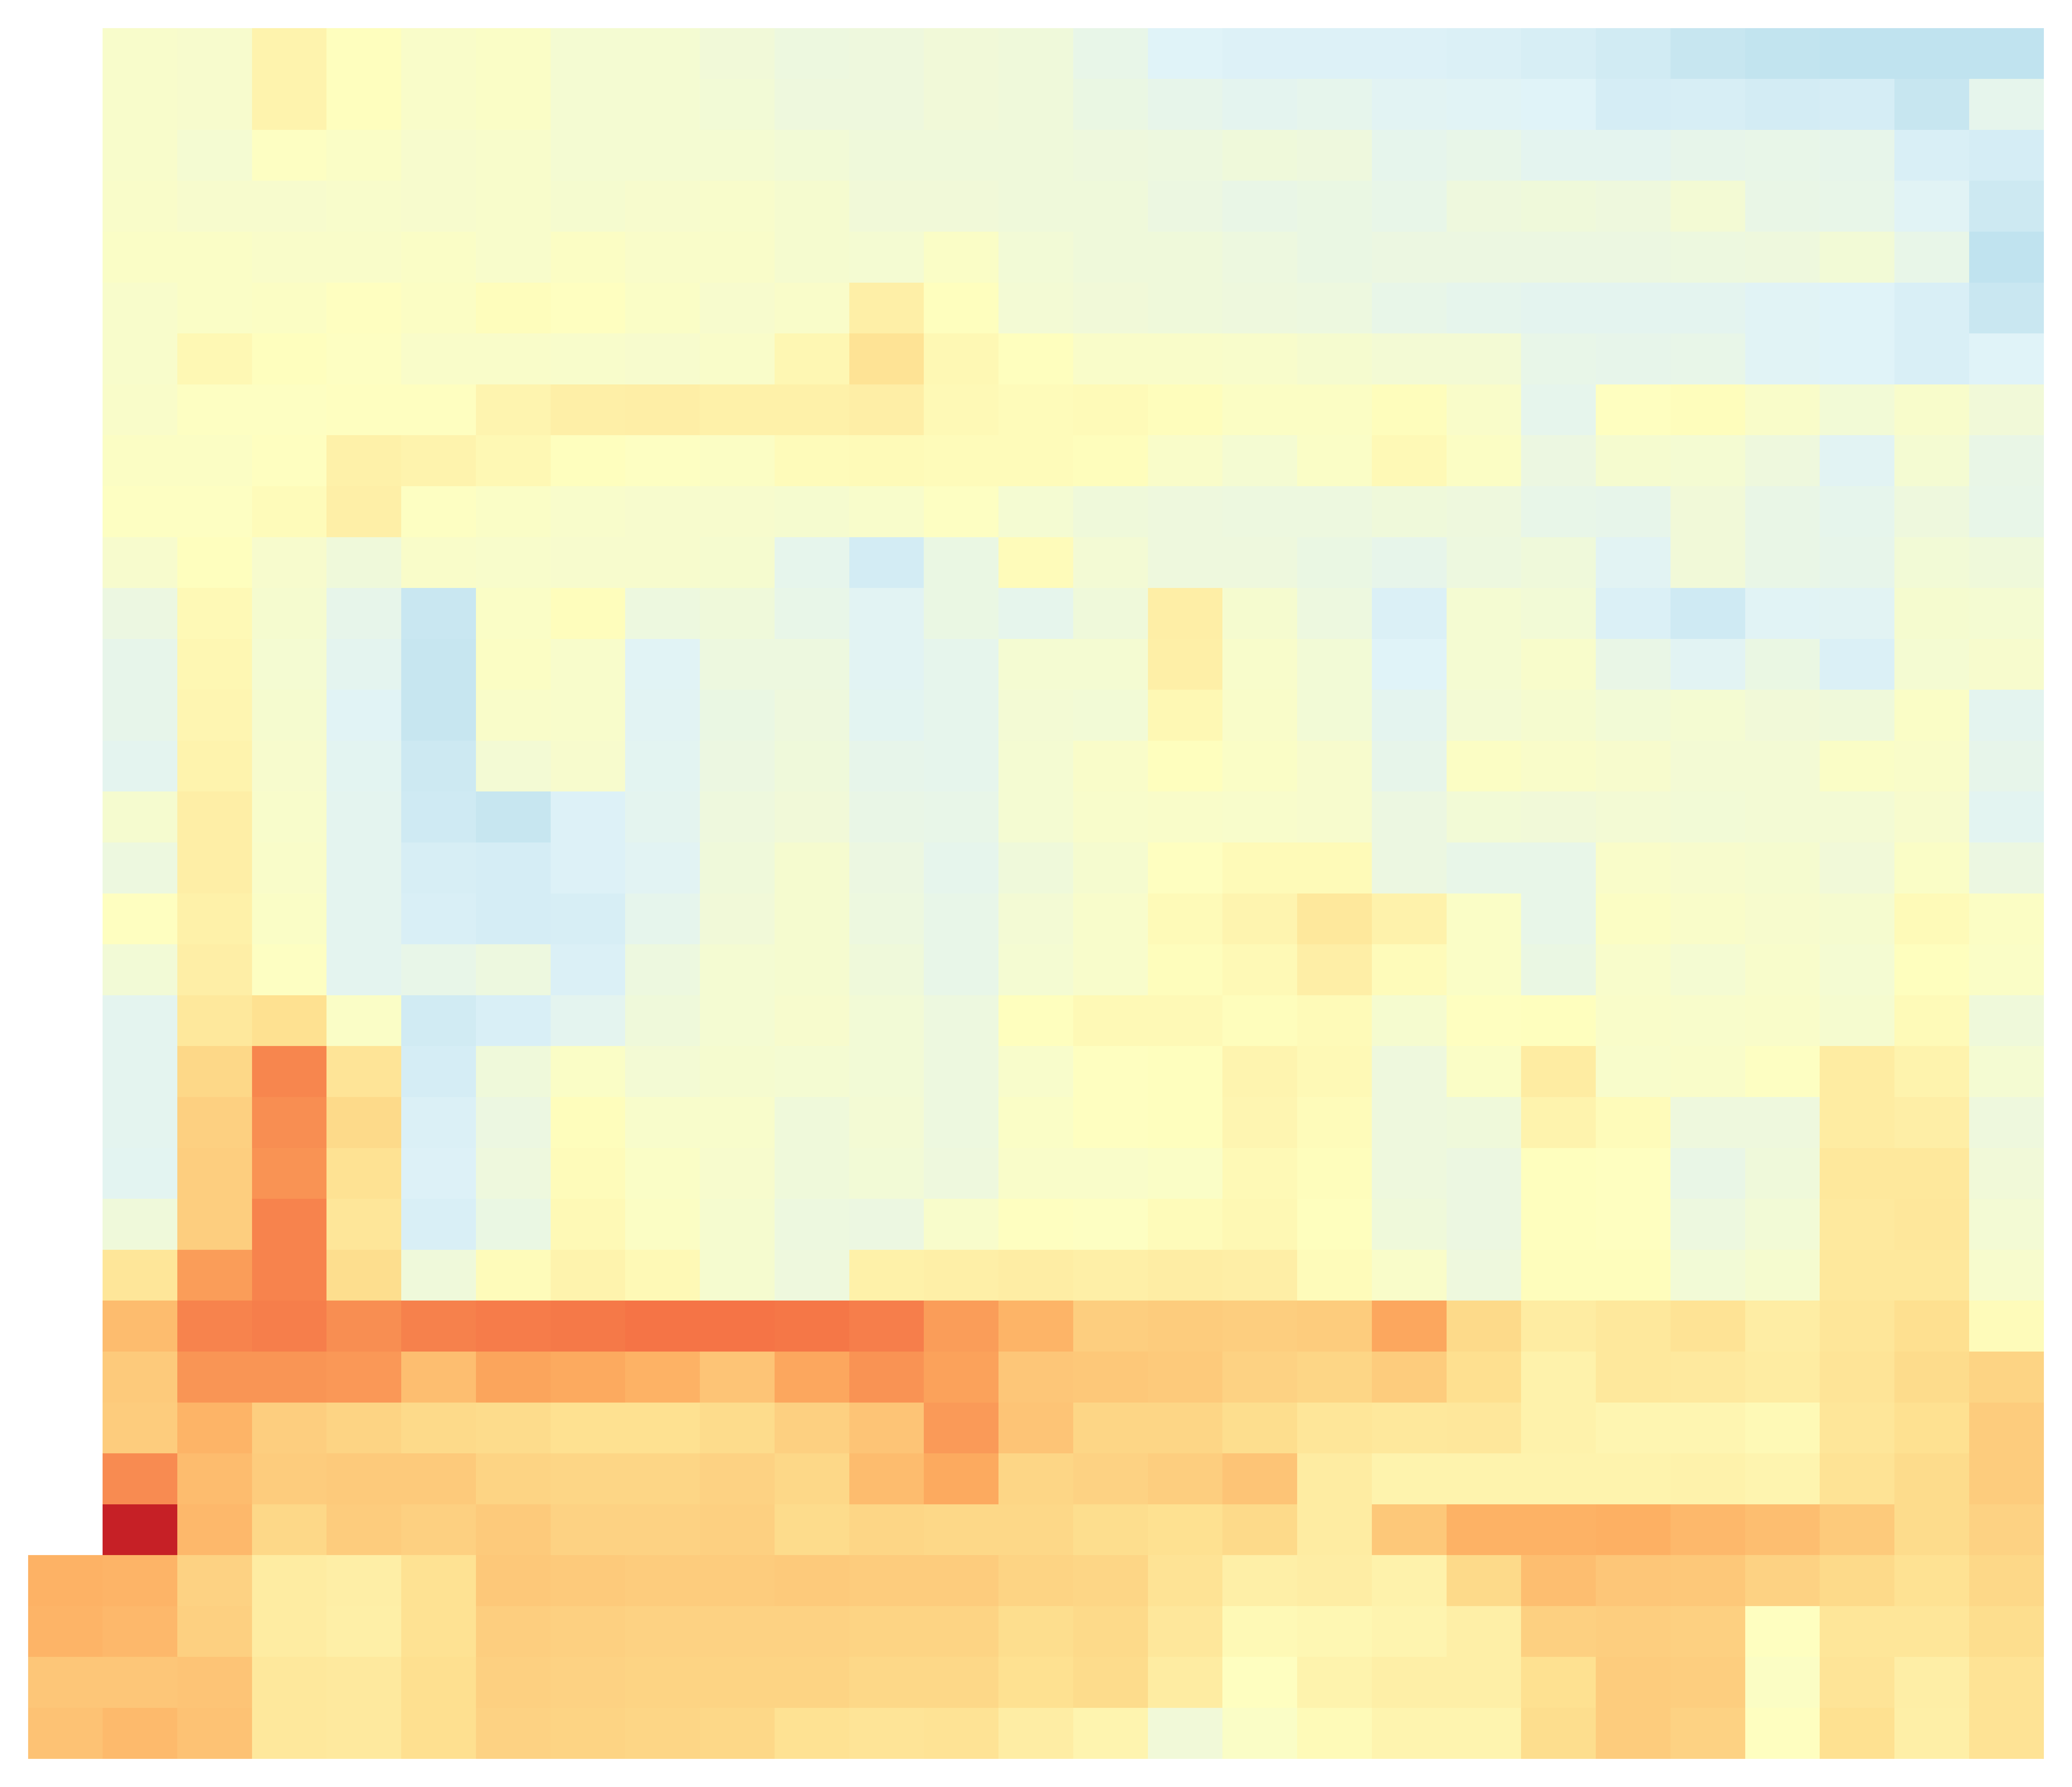

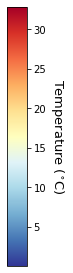

In [15]:
# Save as .kmz file
inputCoords = np.array([[0.106680, 0.108845],[52.204120, 52.204950]])
conv = np.array(myProj([extent[3], extent[2]], [extent[1], extent[0]], inverse=True)) if inputCoords is False else inputCoords
cs, single = plot_kml(xygrid, conv, outName+'_xymerge', 1024*10, rot=90)
_, ds = plot_kml(hf.downsample_arr(xygrid,pxSize,resolution), conv, outName+'_ds_xymerge', 1024*10, rot=90, scale=xygrid)
plot_kml_legend(cs, outName+'_xylegend')
plot_kml_path(idf, conv, outName+'_xypath', 1024*10)
pl.make_kml(conv, figs=[outName+'_xymerge.png', outName+'_ds_xymerge.png', outName+'_xypath.png'], 
            colorbar=outName+'_xylegend.png', kmzfile=outName+'xymerge_thermal.kmz',
            description=str(resolution)+'m resolution thermal imagery', name='Satellite resolution')    

In [20]:
pl.save_to_csv(ds, single, conv, pxSize, resolution, outName+'_xymerge')

In [285]:
def initialise_vars(idf, start, xq, yq, tmin, tmax, path='imgPath'):
    prev = start
    single = ((hf.img_to_arr(idf.iloc[start][path], xq=xq, yq=yq)-tmin)*255/tmax)
    imageio.imwrite(tempfiles[0],np.dstack((single,single,single)))
    prevImg = np.dstack((single,single,single)).astype(np.uint8)
    totalBox=[prevImg.shape[0], prevImg.shape[1]]
    prevBox=[0,prevImg.shape[0],0,prevImg.shape[1]]
    return prev, single, prevImg, totalBox, prevBox

def get_img_translation(trainImg, queryImg, feature_matching='bf', feature_extractor='orb'):
    # Opencv defines the color channel in the order BGR - transform it to RGB to be compatible to matplotlib
    trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]

    # Detect the keypoints and features on both images
    kpsA, featuresA = st.detectAndDescribe(trainImg_gray, method=feature_extractor)
    kpsB, featuresB = st.detectAndDescribe(queryImg_gray, method=feature_extractor)

    # Link  the identified features between images
    if feature_matching == 'bf':
        matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    elif feature_matching == 'knn':
        matches = st.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)

    # Potential to improve by filtering out matches that are not in same direction of travel as drone
    ma = np.array([kpsA[j].pt for j in [i.queryIdx for i in matches]])
    mb = np.array([kpsB[j].pt for j in [i.trainIdx for i in matches]])
    
    diff = np.median(ma-mb, axis=0).astype(int)
    
    return ma, mb, diff

def filter_img_translation(ma, mb, df, num1, num2, movDef=2, x='xc', y='yc'):
    # Filter by only matches in direction of travel
    xmov, ymov = df.iloc[num2][x]-df.iloc[num1][x], df.iloc[num2][y]-df.iloc[num1][y]
    if abs(xmov) < movDef/2 and abs(ymov) < movDef/2:
        mam, mbm = ma, mb
    else: 
        if abs(ymov) > abs(xmov):
            if ymov < 0:
                mam, mbm = ma[[ma[i,0]>mb[i,0] for i in range(len(ma))]], mb[[ma[i,0]>mb[i,0] for i in range(len(ma))]]
            else: mam, mbm = ma[[ma[i,0]>mb[i,0] for i in range(len(ma))]], mb[[ma[i,0]>mb[i,0] for i in range(len(ma))]]
        else:
            if xmov < 0:
                mam, mbm = ma[[ma[i,1]<mb[i,1] for i in range(len(ma))]], mb[[ma[i,1]<mb[i,1] for i in range(len(ma))]]
            else: mam, mbm = ma[[ma[i,1]>mb[i,1] for i in range(len(ma))]], mb[[ma[i,1]>mb[i,1] for i in range(len(ma))]]

    diff = np.median(mam-mbm, axis=0).astype(int)
    
    return mam, mbm, diff


def stitch_img_result(mam, mbm, diff, totalBox, prevBox, img_arrs, prevImg, prevNum, imgNum,
                      min_matches=4, max_stdev=20, tmin=-10, tmax=40, verbose=True, rgb_query=False):
    if verbose: print('Filt. matches: '+str(len(mam))+', stdev: ' + str(round(np.std(mam-mbm, axis=0).mean(),2)))
    
    # Filter for conditions
    if len(mam) > min_matches and np.std(mam-mbm, axis=0).mean() < max_stdev:
        # New box position before adjustment for expanding total box
        newBox=[int(np.round(prevBox[0]+diff[1])), int(np.round(prevBox[1]+diff[1])), int(np.round(prevBox[2]+diff[0])),int(np.round(prevBox[3]+diff[0]))] 
        pos = [0,0] # Position for previously merged images
        modBox = [0,0,0,0] # Position for new image
        
        # If bounds on axis 0 go beyond total
        if newBox[0]<0:
            xmin = imgNum
            modBox[1], modBox[0], pos[0] = newBox[1]-newBox[0], 0, abs(newBox[0])
            totalBox[0]+=abs(newBox[0])
        elif newBox[1] > totalBox[0]:
            xmax = imgNum
            modBox[1], modBox[0], pos[0] = newBox[1], newBox[0], 0
            totalBox[0]=newBox[1]
        else: modBox[0], modBox[1], pos[0] = newBox[0], newBox[1], 0
            
        # If bounds on axis 1 go beyond total
        if newBox[2]<0:
            ymin = imgNum
            modBox[3], modBox[2], pos[1] = newBox[3]-newBox[2], 0, abs(newBox[2])
            totalBox[1]+=abs(newBox[2])
        elif newBox[3] > totalBox[1]:
            ymax = imgNum
            modBox[3], modBox[2], pos[1] = newBox[3], newBox[2], 0
            totalBox[1] = newBox[3]
        else: modBox[2], modBox[3], pos[1] = newBox[2], newBox[3], 0    
        prevBox = modBox  
        
        if len(img_arrs[1].shape) == 2:
            single = (img_arrs[1]-tmin)*255/tmax
            queryImg = np.dstack((single,single,single)).astype(np.uint8)
        else: queryImg = rgb_query
        result = np.zeros([totalBox[0],totalBox[1],3])
        result[pos[0]:pos[0]+prevImg.shape[0],pos[1]:pos[1]+prevImg.shape[1],:] = prevImg
        result[modBox[0]:modBox[1], modBox[2]:modBox[3],:] = queryImg
        print('Images {} and {} merged.'.format(str(prevNum),str(imgNum)))
        prevNum, prevImg = imgNum, result
    else: print('Images {} and {}, poor matching'.format(str(prevNum),str(imgNum)))
    return totalBox, prevNum, prevImg, prevBox

In [132]:
pd.set_option('display.max_colwidth', None)
display(idf)

imgPath  \
52   data/lsm/Flight 1 - Library/thermal-data/20210430_203013_R.npy   
53   data/lsm/Flight 1 - Library/thermal-data/20210430_203014_R.npy   
54   data/lsm/Flight 1 - Library/thermal-data/20210430_203015_R.npy   
55   data/lsm/Flight 1 - Library/thermal-data/20210430_203016_R.npy   
56   data/lsm/Flight 1 - Library/thermal-data/20210430_203017_R.npy   
57   data/lsm/Flight 1 - Library/thermal-data/20210430_203018_R.npy   
58   data/lsm/Flight 1 - Library/thermal-data/20210430_203019_R.npy   
59   data/lsm/Flight 1 - Library/thermal-data/20210430_203020_R.npy   
60   data/lsm/Flight 1 - Library/thermal-data/20210430_203021_R.npy   
61   data/lsm/Flight 1 - Library/thermal-data/20210430_203022_R.npy   
62   data/lsm/Flight 1 - Library/thermal-data/20210430_203023_R.npy   
63   data/lsm/Flight 1 - Library/thermal-data/20210430_203024_R.npy   
64   data/lsm/Flight 1 - Library/thermal-data/20210430_203025_R.npy   
65   data/lsm/Flight 1 - Library/thermal-data/20210430_203026_R.npy   
66   data/lsm/Flight 1 - Library/thermal-data/20210430_203027_R.npy   
67   data/lsm/Flight 1 - Library/thermal-data/20210430_203028_R.npy   
68   data/lsm/Flight 1 - Library/thermal-data/20210430_203029_R.npy   
69   data/lsm/Flight 1 - Library/thermal-data/20210430_203030_R.npy   
86   data/lsm/Flight 1 - Library/thermal-data/20210430_203047_R.npy   
87   data/lsm/Flight 1 - Library/thermal-data/20210430_203048_R.npy   
88   data/lsm/Flight 1 - Library/thermal-data/20210430_203049_R.npy   
89   data/lsm/Flight 1 - Library/thermal-data/20210430_203050_R.npy   
90   data/lsm/Flight 1 - Library/thermal-data/20210430_203051_R.npy   
91   data/lsm/Flight 1 - Library/thermal-data/20210430_203052_R.npy   
93   data/lsm/Flight 1 - Library/thermal-data/20210430_203054_R.npy   
94   data/lsm/Flight 1 - Library/thermal-data/20210430_203055_R.npy   
95   data/lsm/Flight 1 - Library/thermal-data/20210430_203056_R.npy   
96   data/lsm/Flight 1 - Library/thermal-data/20210430_203057_R.npy   
97   data/lsm/Flight 1 - Library/thermal-data/20210430_203058_R.npy   
98   data/lsm/Flight 1 - Library/thermal-data/20210430_203059_R.npy   
99   data/lsm/Flight 1 - Library/thermal-data/20210430_203100_R.npy   
100  data/lsm/Flight 1 - Library/thermal-data/20210430_203101_R.npy   
101  data/lsm/Flight 1 - Library/thermal-data/20210430_203102_R.npy   
102  data/lsm/Flight 1 - Library/thermal-data/20210430_203103_R.npy   
109  data/lsm/Flight 1 - Library/thermal-data/20210430_203110_R.npy   
121  data/lsm/Flight 1 - Library/thermal-data/20210430_203122_R.npy   
122  data/lsm/Flight 1 - Library/thermal-data/20210430_203123_R.npy   
123  data/lsm/Flight 1 - Library/thermal-data/20210430_203124_R.npy   
124  data/lsm/Flight 1 - Library/thermal-data/20210430_203125_R.npy   
125  data/lsm/Flight 1 - Library/thermal-data/20210430_203126_R.npy   
126  data/lsm/Flight 1 - Library/thermal-data/20210430_203127_R.npy   
127  data/lsm/Flight 1 - Library/thermal-data/20210430_203128_R.npy   
128  data/lsm/Flight 1 - Library/thermal-data/20210430_203129_R.npy   
129  data/lsm/Flight 1 - Library/thermal-data/20210430_203130_R.npy   
130  data/lsm/Flight 1 - Library/thermal-data/20210430_203131_R.npy   
131  data/lsm/Flight 1 - Library/thermal-data/20210430_203132_R.npy   
132  data/lsm/Flight 1 - Library/thermal-data/20210430_203133_R.npy   
133  data/lsm/Flight 1 - Library/thermal-data/20210430_203134_R.npy   
134  data/lsm/Flight 1 - Library/thermal-data/20210430_203135_R.npy   
135  data/lsm/Flight 1 - Library/thermal-data/20210430_203136_R.npy   
136  data/lsm/Flight 1 - Library/thermal-data/20210430_203137_R.npy   
137  data/lsm/Flight 1 - Library/thermal-data/20210430_203138_R.npy   
138  data/lsm/Flight 1 - Library/thermal-data/20210430_203139_R.npy   

        timestamp   latitude  longitude  altitude(m)  pitch(deg)  roll(deg)  \
52   1.619811e+12  52.204648   0.108318        120.1         0.4        4.8   
53   1.619811e+12  52.204647   0.108254        120.0        -2.2   

In [157]:
# Multi-image stitching
# Setup variables
if 'result' in globals(): del(result)
#feature_extractor, feature_matching = 'orb', 'bf'
tempfiles = ['temp0.jpg','temp1.jpg']
start, end, step = 0, len(idf), 1
tmin, tmax = -10, 40
imgPath='imgPath'
skips=[]

strips = {}
# Loop over all images
while start < end-1:

    prev, single, prevImg, totalBox, prevBox = initialise_vars(idf, start, xq, yq, tmin, tmax, path=imgPath)
    
    # Loop over images until break in continuous line
    for imgNum in tqdm(np.arange(start+step if start < end else start-step, end, step if start < end else -step)):
        if (np.hypot(abs(idf.iloc[imgNum]['xc']-idf.iloc[imgNum-1]['xc']),abs(idf.iloc[imgNum]['yc']-idf.iloc[imgNum-1]['yc']))) > 10:
            break
        if imgNum in skips: continue # Skip iteration if img in skips
        arrs = [hf.img_to_arr(idf.iloc[i][imgPath], xq=xq, yq=yq) for i in [prev, imgNum]]

        for i, val in enumerate(tempfiles): 
            single = ((arrs[i]+10)*255/40)
            imageio.imwrite(val,np.dstack((single,single,single)))
        # Read images - Make sure that the train image is the image that will be transformed
        trainImg, queryImg = [imageio.imread(i) for i in tempfiles]

        ma, mb, _ = get_img_translation(trainImg, queryImg)

        mam, mbm, diff = filter_img_translation(ma, mb, idf, prev, imgNum)

        totalBox, prevNew, prevImg, prevBox = stitch_img_result(mam, mbm, diff, totalBox, prevBox, arrs, prevImg,
                                                                prev, imgNum, max_stdev=30, verbose=True)
        
        if prevNew < imgNum-3:
            imgNum = prevNew+1
            break
        else: prev=prevNew
        
    if start<imgNum-1: strips.update({start:prevImg})
    start = imgNum
    
for i in strips:
    read = strips[i]
    imageio.imwrite('lib_strips/'+str(i)+'.jpg',np.dstack((read[:,:,0],read[:,:,1],read[:,:,2])))    
# for i in tempfiles: os.remove(i)
# fig = plt.figure(figsize=(20,10))
# plt.imshow(prevImg.mean(axis=2),cmap=cmap)

Lossy conversion from float64 to uint8. Range [128.6450969565037, 222.43562802469813]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 0/52 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [128.6450969565037, 222.43562802469813]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [125.11406410527556, 222.72377836766435]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [128.6450969565037, 222.43562802469813]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [126.29346531021254, 225.4549754591872]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [126.29346531021254, 225.4549754591872]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [12

Raw matches (Brute force): 72
Filt. matches: 1, stdev: 0.0
Images 0 and 1, poor matching
Raw matches (Brute force): 55
Filt. matches: 50, stdev: 6.18
Images 0 and 2 merged.
Raw matches (Brute force): 92
Filt. matches: 91, stdev: 1.36
Images 2 and 3 merged.
Raw matches (Brute force): 116
Filt. matches: 116, stdev: 1.33
Images 3 and 4 merged.
Raw matches (Brute force): 109
Filt. matches: 109, stdev: 1.43
Images 4 and 5 merged.
Raw matches (Brute force): 105
Filt. matches: 103, stdev: 1.19
Images 5 and 6 merged.
Raw matches (Brute force): 95


Lossy conversion from float64 to uint8. Range [125.28269713251333, 232.02129809633394]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [125.11406410527556, 233.1567137189676]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [125.11406410527556, 233.1567137189676]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [125.28269713251333, 222.14735214301362]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█▋        | 9/52 [00:00<00:01, 28.46it/s]Lossy conversion from float64 to uint8. Range [125.28269713251333, 222.14735214301362]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [123.42502367882362, 223.44360602918687]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8

Filt. matches: 91, stdev: 1.36
Images 6 and 7 merged.
Raw matches (Brute force): 121
Filt. matches: 96, stdev: 12.21
Images 7 and 8 merged.
Raw matches (Brute force): 159
Filt. matches: 157, stdev: 1.34
Images 8 and 9 merged.
Raw matches (Brute force): 207
Filt. matches: 206, stdev: 1.37
Images 9 and 10 merged.
Raw matches (Brute force): 219
Filt. matches: 217, stdev: 1.33
Images 10 and 11 merged.
Raw matches (Brute force): 254
Filt. matches: 251, stdev: 1.69
Images 11 and 12 merged.


Lossy conversion from float64 to uint8. Range [62.5587968320804, 228.46066310517153]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [62.5587968320804, 228.46066310517153]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [67.63320453831008, 228.88894236166448]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [67.63320453831008, 228.88894236166448]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [54.950470403973064, 237.53842530222997]. Convert image to uint8 prior to saving to suppress this warning.
 29%|██▉       | 15/52 [00:00<00:01, 28.04it/s]Lossy conversion from float64 to uint8. Range [54.950470403973064, 237.53842530222997]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. R

Raw matches (Brute force): 155
Filt. matches: 151, stdev: 1.2
Images 12 and 13 merged.
Raw matches (Brute force): 130
Filt. matches: 130, stdev: 1.17
Images 13 and 14 merged.
Raw matches (Brute force): 85
Filt. matches: 83, stdev: 1.21
Images 14 and 15 merged.
Raw matches (Brute force): 70
Filt. matches: 70, stdev: 1.15
Images 15 and 16 merged.
Raw matches (Brute force): 27
Filt. matches: 10, stdev: 73.74
Images 16 and 17, poor matching
Raw matches (Brute force): 127
Filt. matches: 122, stdev: 9.99
Images 18 and 19 merged.


Lossy conversion from float64 to uint8. Range [15.748095287568574, 213.87803016332927]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [20.280043229762292, 213.29379590528714]. Convert image to uint8 prior to saving to suppress this warning.
  9%|▉         | 3/34 [00:00<00:01, 28.94it/s]Lossy conversion from float64 to uint8. Range [20.280043229762292, 213.29379590528714]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [22.326436164074885, 213.87803016332927]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [22.326436164074885, 213.87803016332927]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [26.191636561576228, 213.14765571721574]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uin

Raw matches (Brute force): 140
Filt. matches: 139, stdev: 12.05
Images 19 and 20 merged.
Raw matches (Brute force): 146
Filt. matches: 145, stdev: 7.65
Images 20 and 21 merged.
Raw matches (Brute force): 128
Filt. matches: 127, stdev: 8.56
Images 21 and 22 merged.
Raw matches (Brute force): 106
Filt. matches: 105, stdev: 6.72
Images 22 and 23 merged.
Raw matches (Brute force): 44
Filt. matches: 43, stdev: 21.84
Images 23 and 24 merged.
Raw matches (Brute force): 29
Filt. matches: 21, stdev: 50.91
Images 24 and 25, poor matching


Lossy conversion from float64 to uint8. Range [38.00853268081988, 209.63043492585334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [90.34194161065092, 195.96789379154515]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [38.00853268081988, 209.63043492585334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [94.45214469805505, 194.4651600115057]. Convert image to uint8 prior to saving to suppress this warning.
 26%|██▋       | 9/34 [00:00<00:00, 26.82it/s]
Lossy conversion from float64 to uint8. Range [86.20083944524124, 180.62393410748535]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 0/27 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [86.20083944524124, 180.62393410748535]. Convert image to uint8 prior to saving to suppress this warning.
Loss

Raw matches (Brute force): 20
Filt. matches: 6, stdev: 43.25
Images 24 and 26, poor matching
Raw matches (Brute force): 27
Filt. matches: 6, stdev: 59.76
Images 24 and 27, poor matching
Raw matches (Brute force): 28
Filt. matches: 7, stdev: 62.0
Images 24 and 28, poor matching
Raw matches (Brute force): 54
Filt. matches: 46, stdev: 24.22
Images 25 and 26 merged.
Raw matches (Brute force): 70
Filt. matches: 66, stdev: 17.98
Images 26 and 27 merged.
Raw matches (Brute force): 101
Filt. matches: 96, stdev: 35.39
Images 27 and 28, poor matching


Lossy conversion from float64 to uint8. Range [90.34194161065092, 195.96789379154515]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [90.16254087094867, 239.64843381249415]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [90.34194161065092, 195.96789379154515]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [92.66885539472688, 260.6699524434845]. Convert image to uint8 prior to saving to suppress this warning.
 19%|█▊        | 5/27 [00:00<00:00, 25.66it/s]
Lossy conversion from float64 to uint8. Range [94.45214469805505, 194.4651600115057]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 0/24 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [94.45214469805505, 194.4651600115057]. Convert image to uint8 prior to saving to suppress this warning.
Lossy 

Raw matches (Brute force): 66
Filt. matches: 54, stdev: 35.66
Images 27 and 29, poor matching
Raw matches (Brute force): 28
Filt. matches: 9, stdev: 33.81
Images 27 and 30, poor matching
Raw matches (Brute force): 37
Filt. matches: 26, stdev: 53.69
Images 27 and 31, poor matching
Raw matches (Brute force): 101
Filt. matches: 91, stdev: 31.13
Images 28 and 29, poor matching
Raw matches (Brute force): 33
Filt. matches: 11, stdev: 46.96
Images 28 and 30, poor matching
Raw matches (Brute force): 46
Filt. matches: 13, stdev: 46.11
Images 28 and 31, poor matching
Raw matches (Brute force): 53
Filt. matches: 29, stdev: 45.28
Images 28 and 32, poor matching



Lossy conversion from float64 to uint8. Range [93.91776093077985, 197.46709834989858]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 0/23 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [93.91776093077985, 197.46709834989858]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [90.16254087094867, 239.64843381249415]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [93.91776093077985, 197.46709834989858]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [92.66885539472688, 260.6699524434845]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [92.66885539472688, 260.6699524434845]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [107.

Raw matches (Brute force): 27
Filt. matches: 13, stdev: 31.72
Images 29 and 30, poor matching
Raw matches (Brute force): 49
Filt. matches: 19, stdev: 29.87
Images 29 and 31 merged.
Raw matches (Brute force): 60
Filt. matches: 58, stdev: 10.75
Images 31 and 32 merged.
Raw matches (Brute force): 56
Filt. matches: 41, stdev: 41.36
Images 32 and 33, poor matching
Raw matches (Brute force): 160
Filt. matches: 159, stdev: 10.55
Images 35 and 36 merged.
Raw matches (Brute force): 150
Filt. matches: 142, stdev: 2.29
Images 36 and 37 merged.


Lossy conversion from float64 to uint8. Range [102.75780729761911, 183.232868637423]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [111.11507833245957, 185.2206388966892]. Convert image to uint8 prior to saving to suppress this warning.
 18%|█▊        | 3/17 [00:00<00:00, 27.94it/s]Lossy conversion from float64 to uint8. Range [111.11507833245957, 185.2206388966892]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [114.56118437858038, 188.11459386701154]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [114.56118437858038, 188.11459386701154]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [108.86383914847549, 187.65853565233257]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. 

Raw matches (Brute force): 167
Filt. matches: 165, stdev: 3.81
Images 37 and 38 merged.
Raw matches (Brute force): 177
Filt. matches: 174, stdev: 11.22
Images 38 and 39 merged.
Raw matches (Brute force): 162
Filt. matches: 157, stdev: 6.57
Images 39 and 40 merged.
Raw matches (Brute force): 137
Filt. matches: 135, stdev: 1.46
Images 40 and 41 merged.
Raw matches (Brute force): 101
Filt. matches: 93, stdev: 15.05
Images 41 and 42 merged.
Raw matches (Brute force): 108
Filt. matches: 101, stdev: 17.03
Images 42 and 43 merged.


 53%|█████▎    | 9/17 [00:00<00:00, 28.19it/s]Lossy conversion from float64 to uint8. Range [103.10851498300204, 188.570322987155]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [101.17690082188948, 189.6324149336179]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [101.17690082188948, 189.6324149336179]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [102.93318855397816, 189.17745106292358]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [102.93318855397816, 189.17745106292358]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [102.93318855397816, 186.897705454635]. Convert image to uint8 prior to saving to suppress this warning.
 71%|███████   | 12/17 [00:00<00:00, 27.68

Raw matches (Brute force): 143
Filt. matches: 140, stdev: 3.64
Images 43 and 44 merged.
Raw matches (Brute force): 183
Filt. matches: 181, stdev: 11.14
Images 44 and 45 merged.
Raw matches (Brute force): 200
Filt. matches: 198, stdev: 4.2
Images 45 and 46 merged.
Raw matches (Brute force): 203
Filt. matches: 201, stdev: 3.32
Images 46 and 47 merged.
Raw matches (Brute force): 202
Filt. matches: 196, stdev: 3.32
Images 47 and 48 merged.
Raw matches (Brute force): 155
Filt. matches: 147, stdev: 3.04
Images 48 and 49 merged.


Lossy conversion from float64 to uint8. Range [102.23133408441801, 201.64629636267776]. Convert image to uint8 prior to saving to suppress this warning.
 88%|████████▊ | 15/17 [00:00<00:00, 27.65it/s]Lossy conversion from float64 to uint8. Range [102.23133408441801, 201.64629636267776]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [105.38279098219907, 190.08705196540774]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [105.38279098219907, 190.08705196540774]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [106.080721864262, 186.74542921106564]. Convert image to uint8 prior to saving to suppress this warning.
100%|██████████| 17/17 [00:00<00:00, 28.09it/s]

Raw matches (Brute force): 131
Filt. matches: 129, stdev: 2.32
Images 49 and 50 merged.
Raw matches (Brute force): 36
Filt. matches: 32, stdev: 11.03
Images 50 and 51 merged.
Raw matches (Brute force): 30
Filt. matches: 17, stdev: 53.85
Images 51 and 52, poor matching


In [191]:
"""Import functions"""
def img_to_arr(filepath, xq=False, yq=False):
    if '.npy' in filepath: 
        arr = np.load(filepath)
        if xq and yq: arr = arr[yq:arr.shape[0]-yq,xq:arr.shape[1]-xq]
    else:
        img = ro.open(filepath)
        read = img.read()[:, yq:img.shape[0]-yq,xq:img.shape[1]-xq] if xq and yq else img.read()
        arr = np.dstack((read[0],read[1],read[2]))/255  
    return arr

Raw matches (Brute force): 15
Raw matches (Brute force): 15


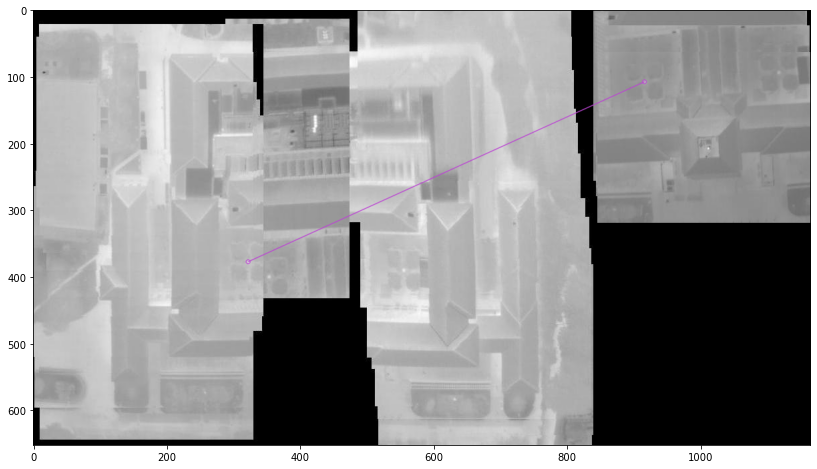

In [391]:
tempfiles = ['lib_strips/p3_s2.jpg','lib_strips/29.jpg']
feature_extractor = 'orb'
arrs = [img_to_arr(tempfiles[0], xq=xq, yq=yq), img_to_arr(tempfiles[1], xq=xq, yq=yq)]
trainImg, queryImg = [imageio.imread(i) for i in tempfiles]
trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]
kpsA, featuresA = st.detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = st.detectAndDescribe(queryImg_gray, method=feature_extractor)
matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
fig = plt.figure(figsize=(20,8))
if feature_matching == 'bf':
    matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    from itertools import compress
    margins = [250, 350, 0, 500]
    matchesUsed = list(compress(matches,[kpsA[i.queryIdx].pt[0] > margins[0]
                                         and kpsA[i.queryIdx].pt[0] < margins[1]
                                         and kpsA[i.queryIdx].pt[1] > margins[2]
                                         and kpsA[i.queryIdx].pt[1] < margins[3]
                                         for i in matches]))
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matchesUsed[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = st.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Filt. matches: 1, stdev: 0.0
t_i[652, 839]
new[269, 588, 245, 571]
m[269, 588, 245, 571]
t[652, 839]
Images 0 and 1 merged.


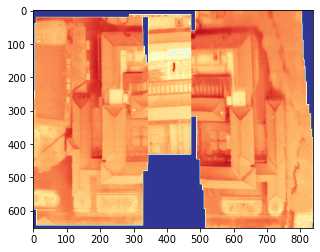

In [393]:
# Potential to improve by filtering out matches that are not in same direction of travel as drone
ma = np.array([kpsA[j].pt for j in [i.queryIdx for i in matchesUsed]])
mb = np.array([kpsB[j].pt for j in [i.trainIdx for i in matchesUsed]])
diff = np.median(ma-mb, axis=0).astype(int)
totalBox=[trainImg.shape[0], trainImg.shape[1]]
prevBox=[0,trainImg.shape[0],0,trainImg.shape[1]]
prevImg = np.ma.masked_where(trainImg < 1e-1, trainImg)

totalBox, prevNew, prevImg, prevBox = stitch_img_result(ma, mb, diff, totalBox, prevBox, arrs, prevImg, prevNum, imgNum=1,
                      min_matches=0, max_stdev=20, tmin=-10, tmax=40, verbose=True, rgb_query=queryImg, inv=True)
plt.imshow(prevImg.mean(axis=2),cmap=cmap)
single = prevImg.mean(axis=2)
imageio.imwrite('lib_strips/p3.jpg',np.dstack((single,single,single)))   

In [380]:
def stitch_img_result(mam, mbm, diff, totalBox, prevBox, img_arrs, prevImg, prevNum, imgNum,
                      min_matches=4, max_stdev=20, tmin=-10, tmax=40, verbose=True, rgb_query=False,inv=False):
    if verbose: print('Filt. matches: '+str(len(mam))+', stdev: ' + str(round(np.std(mam-mbm, axis=0).mean(),2)))
    print('t_i'+str(totalBox))
    # Filter for conditions
    if len(mam) > min_matches and np.std(mam-mbm, axis=0).mean() < max_stdev:
        # New box position before adjustment for expanding total box
        if rgb_query is not False:
            newBox=[int(np.round(prevBox[0]+diff[1])), int(np.round(prevBox[0]+diff[1]))+rgb_query.shape[0], int(np.round(prevBox[2]+diff[0])),int(np.round(prevBox[2]+diff[0]))+rgb_query.shape[1]] 
        else: newBox=[int(np.round(prevBox[0]+diff[1])), int(np.round(prevBox[1]+diff[1])), int(np.round(prevBox[2]+diff[0])),int(np.round(prevBox[3]+diff[0]))] 
        pos = [0,0] # Position for previously merged images
        modBox = [0,0,0,0] # Position for new image
        print('new'+str(newBox))
        # If bounds on axis 0 go beyond total
        if newBox[0]<0 and newBox[1] > totalBox[0]:
            xmin = imgNum
            xmax = imgNum
            modBox[1], modBox[0], pos[0] = newBox[1]-newBox[0], 0, abs(newBox[0])
            totalBox[0]=newBox[1]-min(newBox[0],0)
        elif newBox[0]<0:
            print('a')
            xmin = imgNum
            modBox[1], modBox[0], pos[0] = newBox[1]-newBox[0], 0, abs(newBox[0])
            totalBox[0]+=abs(newBox[0])
        elif newBox[1] > totalBox[0]:
            print('b')
            xmax = imgNum
            modBox[1], modBox[0], pos[0] = newBox[1], newBox[0], 0
            totalBox[0]=newBox[1]
        else: modBox[0], modBox[1], pos[0] = newBox[0], newBox[1], 0#newBox[0]>0 and newBox[1] < totalBox[0]:
            
            
        # If bounds on axis 1 go beyond total
        if newBox[2]<0:
            print('c')
            ymin = imgNum
            modBox[3], modBox[2], pos[1] = newBox[3]-newBox[2], 0, abs(newBox[2])
            totalBox[1]+=abs(newBox[2])
        if newBox[3] > totalBox[1]:
            print('d')
            ymax = imgNum
            modBox[3], modBox[2], pos[1] = newBox[3], newBox[2], 0
            totalBox[1] = newBox[3]-min(newBox[2],0)
        if newBox[2]>0 and newBox[3] < totalBox[1]:
            modBox[2], modBox[3], pos[1] = newBox[2], newBox[3], 0 
        prevBox = modBox 
        print('m'+str(modBox))
        print('t'+str(totalBox))
        
        if len(img_arrs[1].shape) == 2:
            single = (img_arrs[1]-tmin)*255/tmax
            queryImg = np.dstack((single,single,single)).astype(np.uint8)
        else: queryImg = rgb_query
        result = np.zeros([totalBox[0],totalBox[1],3])
        if inv:
            result[modBox[0]:modBox[1], modBox[2]:modBox[3],:] = queryImg
            result[pos[0]:pos[0]+prevImg.shape[0],pos[1]:pos[1]+prevImg.shape[1],:] = prevImg
        else:    
            result[pos[0]:pos[0]+prevImg.shape[0],pos[1]:pos[1]+prevImg.shape[1],:] = prevImg
            result[modBox[0]:modBox[1], modBox[2]:modBox[3],:] = queryImg
        print('Images {} and {} merged.'.format(str(prevNum),str(imgNum)))
        prevNum, prevImg = imgNum, result
    else: print('Images {} and {}, poor matching'.format(str(prevNum),str(imgNum)))
    return totalBox, prevNum, prevImg, prevBox

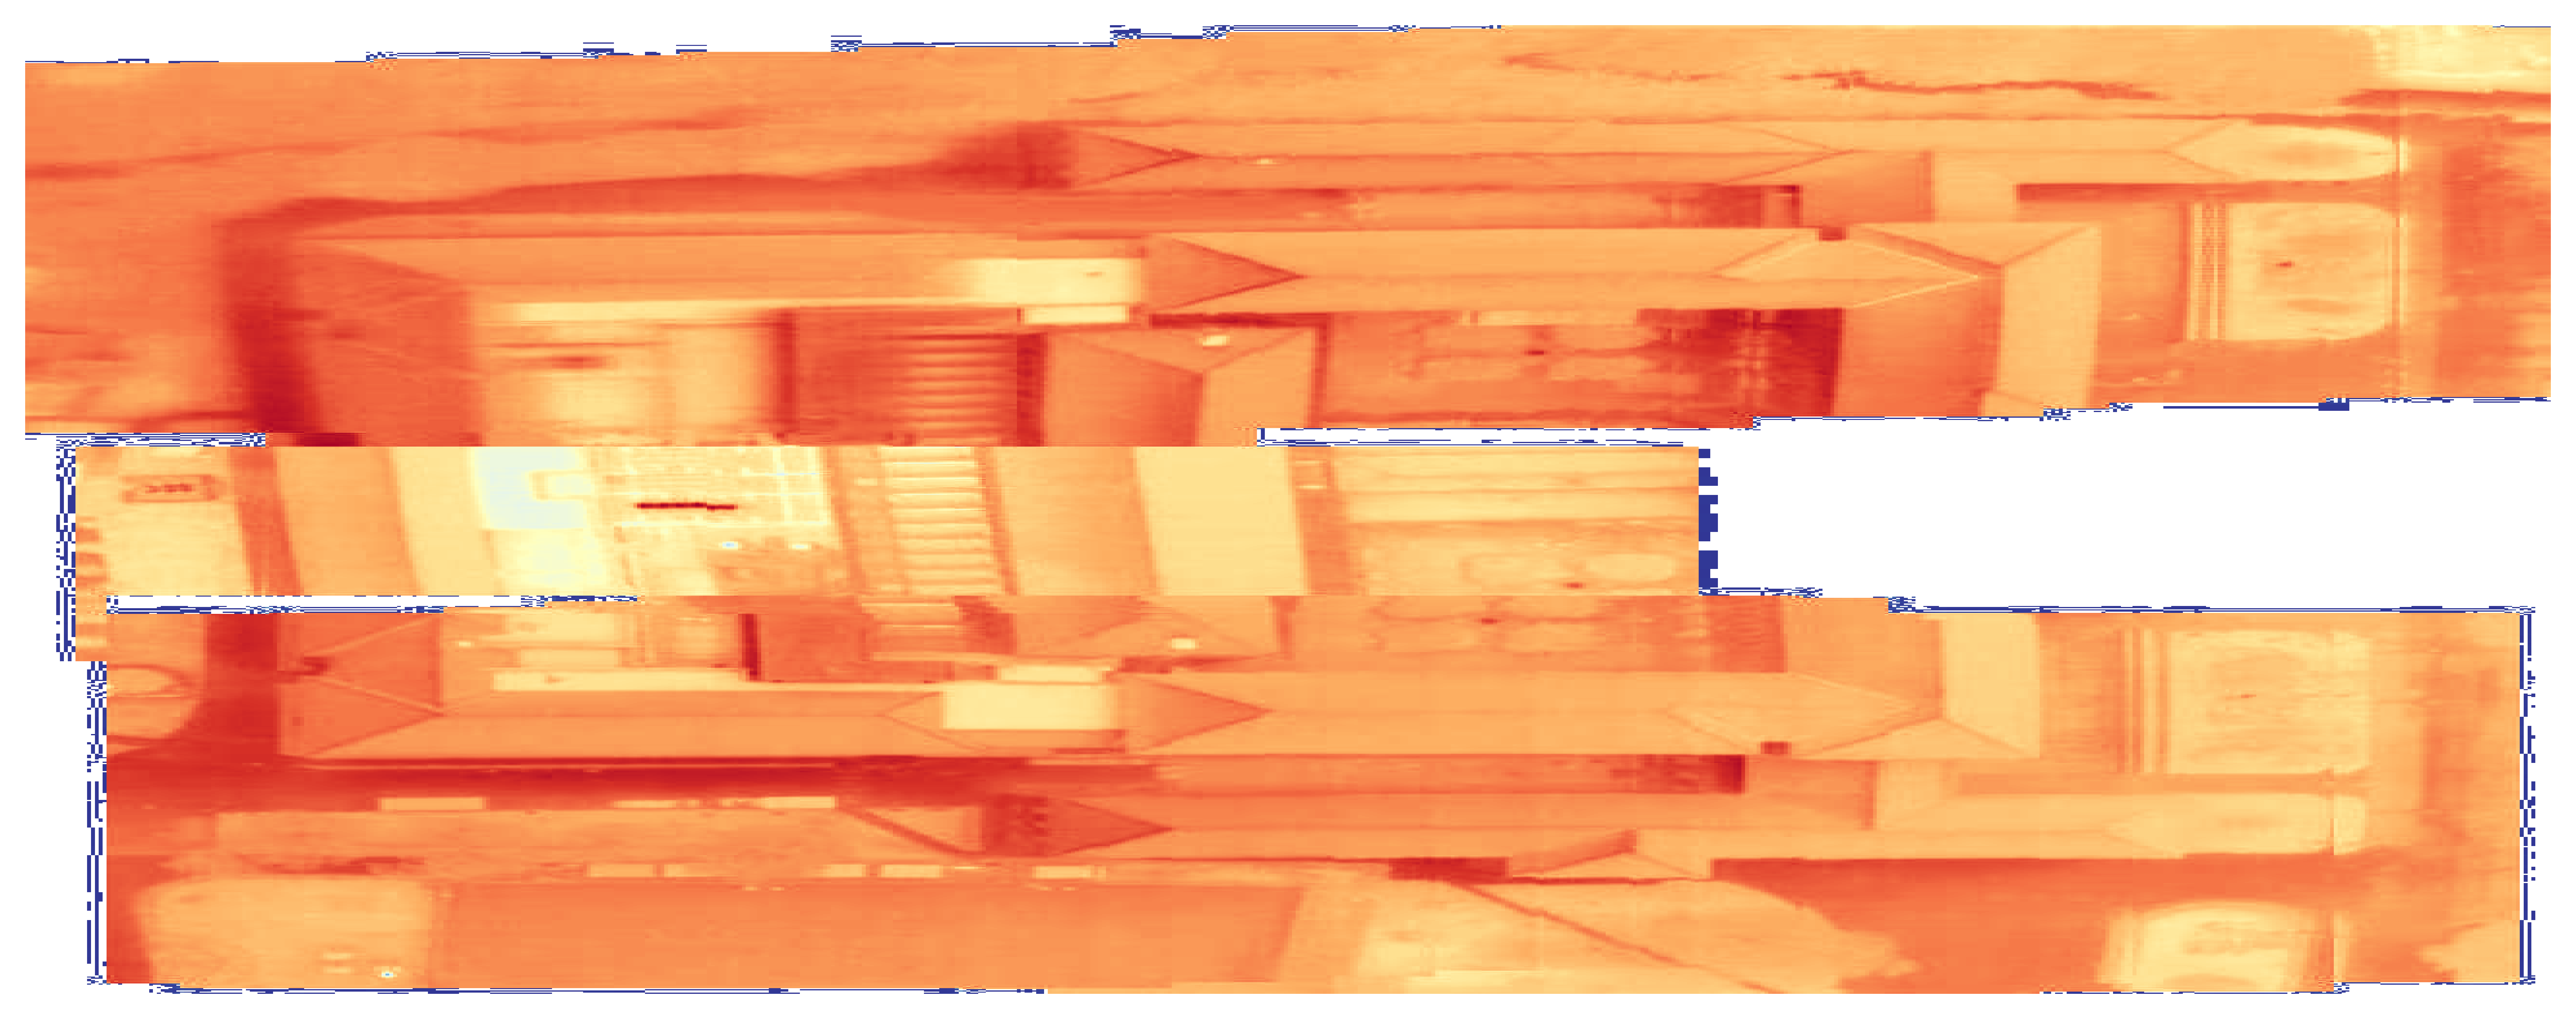

In [395]:
# Save as kmz
result = prevImg
inputCoords = True
userInputCoords = np.array([[0.106680, 0.108845],[52.204120, 52.204950]])
pixels = 1024 * 10
cmap = colorbrewer.get_map('RdYlBu', 'diverging', 11, reverse=True).mpl_colormap
if inputCoords: conv = userInputCoords
else: conv = np.array(myProj([idf.iloc[xmin]['yc']-pxSize*(np.floor(queryImg.shape[0]/2)+0.5), idf.iloc[xmax]['yc']+pxSize*(np.floor(queryImg.shape[0]/2)+0.5)],
                       [idf.iloc[ymin]['xc']-pxSize*(np.floor(queryImg.shape[1]/2)+0.5), idf.iloc[ymax]['xc']+pxSize*(np.floor(queryImg.shape[1]/2)+0.5)], inverse=True))
fig, ax = pl.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                         pixels=pixels)

rot = ndimage.rotate(result.mean(axis=2), 90)
single = np.ma.masked_where(rot < 1e-1, rot)/255*40-10
cs = ax.imshow(single,extent=(conv[0].min(),conv[0].max(),conv[1].min(),conv[1].max()), cmap=cmap, vmin=single.min(),vmax=single.max())
ax.set_axis_off()
fig.savefig('original0-25.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
resolution = 6
fig, ax = hf.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                         pixels=pixels)
#ds = hf.downsample_arr(single,pxSize,resolution)
#single = rot/255*50-10
ds = np.ma.masked_where(abs(hf.downsample_arr(single.filled(),pxSize,resolution)) > 1e3, hf.downsample_arr(single,pxSize,resolution))
cs = ax.imshow(ds,extent=(conv[0].min(),conv[0].max(),conv[1].min(),conv[1].max()), cmap=cmap, vmin=single.min(),vmax=single.max())
ax.set_axis_off()
fig.savefig('downsample0-25.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig = plt.figure(figsize=(1.0, 4.0))
ax = fig.add_axes([0.07, 0.05, 0.27, 0.9])
cb = fig.colorbar(cs, cax=ax)
cb.set_label('Temperature ($^{\circ}$C)', rotation=-90, color='k', labelpad=20, fontsize=13)
fig.tight_layout()
fig.savefig('legend.png', format='png', bbox_inches = 'tight', pad_inches = 0.2) 

In [ ]:
#Flight Path
stop = 25
x, y = idf.longitude[:stop], idf.latitude[:stop]
fig, ax = hf.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                         pixels=pixels)
ax.plot(x,y,'k-',linewidth=2,label='raw')
ax.set_axis_off()
fig.savefig('path0-25.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
hf.make_kml(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
         figs=['overlay1.png', 'overlay2.png','path.png'], colorbar='legend.png',
         kmzfile='stitch_thermal.kmz', description=str(resolution)+'m resolution thermal imagery', name='Satellite resolution')

In [ ]:
# Save as .csv file
ds_arr = ds.shape
ptslon = np.linspace(conv[0].min(),conv[0].max(),ds_arr[1]+1)[:-1]
ptslon += (ptslon[1]-ptslon[0])/2
ptslat = np.linspace(conv[1].min(),conv[1].max(),ds_arr[0]+1)[:-1]
ptslat += (ptslat[1]-ptslat[0])/2
lonm, latm = np.meshgrid(ptslon,ptslat)

import pandas as pd
ds_q = int(np.floor(resolution/pxSize))
arr = np.round(single[:-(single.shape[0] % ds_q),:-(single.shape[1] % ds_q)]).astype(int)
most=np.zeros([len(range(0,arr.shape[0]-ds_q,ds_q))+1, len(range(0,arr.shape[1]-ds_q,ds_q))+1])
for i in range(0,arr.shape[0],ds_q):
    for j in range(0,arr.shape[1],ds_q):
        most[int(i/ds_q),int(j/ds_q)] = Counter(arr[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0]
        
tdf = pd.DataFrame(np.concatenate([np.flip(latm.reshape(-1,1)), lonm.reshape(-1,1), ds.reshape(-1,1), most.reshape(-1,1)], axis=1), columns=['Latitude', 'Longitude', '6m T(C)', '0.27cm T(C)'])
filt = tdf[ds.mask.reshape(-1,1) == False]
filt.to_csv('plots/stitch_temps.csv', index_label='UID')